In [1]:
import os
import datetime as dt
import pandas as pd
import csv

#### Importing Project Libraries

In [2]:
# add the 'src' directory as one where we can import modules
import sys
import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent 
src_dir = str(PROJ_ROOT / 'src')
PROJ_ROOT = str(PROJ_ROOT)
sys.path.append(src_dir)
from data import make_dataset

### Confirm that the core data is up to date

In [3]:
manual_usernames = ['emily', '+vinny', 'jake', 'hayyogirl', 'Rabbit', 'username']
# manual_usernames = ['inreverie', 'jake', 'username', 'rabbit',
#        'hayyogirl', '+vinny', 'joeybars7', 'joeybars', 'rusty', 'upstate518',
#        'fenderman123', 'philoiz', 'ceecee', 'anonysauce', 'keirmaley',
#        'nepthys', 'plush.mary', 'jmeow', 'shanila', 'google', 'nimaghafari']
today = dt.date.today()
usernames = make_dataset.refresh_user_data(manual_usernames, PROJ_ROOT, today)
# Re-pulls raw data and refreshes basic interim data files: users_df.pkl 
# and a bunch for each user: filename + username + '.pkl'
#   contacts_df_, day_comm_log_df_, week_comm_log_df_
#   locations_df_, loc_log_df_, day_loc_log_df_, week_loc_log_df_

Interim users_df datafile exists
Data is up to date!


#### Set Interested Date Indices

In [4]:
date_indices = pd.date_range(today - dt.timedelta(35), today + dt.timedelta(0), freq='W-MON')
print(date_indices)

DatetimeIndex(['2018-12-31', '2019-01-07', '2019-01-14', '2019-01-21',
               '2019-01-28'],
              dtype='datetime64[ns]', freq='W-MON')


### Establish interim data path, open some data files

In [5]:
from data import user_df_setup

interim_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim",
                                 "full_users_df.pkl")
users_df = pd.read_pickle(interim_data_file_path)
raw_data_file_path = os.path.join(PROJ_ROOT,
                             "data",
                             "raw",
                             "users_df.pkl")
raw_users_df = pd.read_pickle(raw_data_file_path)

# raw_users_df
# raw_users_df[['username', 'timeCreated']].sort_values('timeCreated', ascending = False).head(20)
# all_users_df.sort_values('date_created', ascending = False).head(20)
# all_users_df.head(20)

#### Pulling communication, location data into user dictionaries

In [6]:
interim_data_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "interim")
raw_data_file_path = os.path.join(PROJ_ROOT,
                                 "data",
                                 "raw")
daily_comm_dict = {}

for username in usernames:
    interim_comm_data_file_path = os.path.join(interim_data_path, 'day_comm_log_df_' + username + '.pkl')
    daily_comm_df = pd.read_pickle(interim_comm_data_file_path)
    daily_comm_dict[username] = daily_comm_df
    
#     interim_contact_data_file_path = os.path.join(interim_data_path, 'contacts_df_' + username + '.pkl')
#     contacts_df = pd.read_pickle(interim_contact_data_file_path)
#     contacts_dict[username] = contacts_df
    
#     interim_loc_data_file_path = os.path.join(interim_data_path, 'week_loc_log_df_' + username + '.pkl')
#     weekly_loc_log_df = pd.read_pickle(interim_loc_data_file_path)
#     weekly_loc_log_dict[username] = weekly_loc_log_df
    
#     locations_data_file_path = os.path.join(interim_data_path, 'locations_df_' + username + '.pkl')
#     locations_df = pd.read_pickle(locations_data_file_path)
#     locations_dict[username] = locations_df

In [32]:
daily_comm_dict['emily'].columns

Index(['sms_sent_risky', 'sms_sent_neutral', 'sms_sent_supportive',
       'sms_sent_unrated', 'sms_received_risky', 'sms_received_neutral',
       'sms_received_supportive', 'sms_received_unrated',
       'phone_inbound_risky', 'phone_inbound_neutral',
       'phone_inbound_supportive', 'phone_inbound_unrated',
       'phone_outbound_risky', 'phone_outbound_neutral',
       'phone_outbound_supportive', 'phone_outbound_unrated', 'total_comm',
       'risky_comm', 'neutral_comm', 'supportive_comm', 'unrated_comm'],
      dtype='object')

## Pull in Firebase Data

In [14]:
from google.cloud import bigquery

import pathlib # __file__ isn't recognized in Jupyter, so we need this to get the root path
path = pathlib.Path.cwd()
PROJ_ROOT = path.parent

accountkeyfile = str(PROJ_ROOT.parent / 'credentials\GoogleServiceAccountKeyFile.json')
client = bigquery.Client.from_service_account_json(accountkeyfile)

In [29]:
query = """
SELECT
    event_date AS Date,
    SUM(CASE WHEN event_name = "risky_sent_sms_warning_event" THEN 1 ELSE 0 END) AS risky_sent_sms,
    SUM(CASE WHEN event_name = "risky_sent_sms_warning_notification" THEN 1 ELSE 0 END) AS risky_sent_notification,
    SUM(CASE WHEN event_name = "risky_sms_event" THEN 1 ELSE 0 END) AS risky_in_sms,
    SUM(CASE WHEN event_name = "risky_sms_warning_notification" THEN 1 ELSE 0 END) AS risky_in_notification,
    user_properties.value.string_value AS username,
    COUNT(event_name) AS total_risly_sms_events
FROM 
    `analytics_153084895.events_*`,
    UNNEST(user_properties) AS user_properties
WHERE
    user_properties.value.string_value in ("{}")
    AND (event_name = "risky_sent_sms_warning_event"
        OR event_name = "risky_sent_sms_warning_notification"
        OR event_name = "risky_sms_event"
        OR event_name = "risky_sms_warning_notification")
GROUP BY
    event_date, user_properties.value.string_value
ORDER BY
    event_date DESC
""".format('", "'.join(map(str, usernames)))
print(query)
df = client.query(query).to_dataframe()
df.head(10)


SELECT
    event_date AS Date,
    SUM(CASE WHEN event_name = "risky_sent_sms_warning_event" THEN 1 ELSE 0 END) AS risky_sent_sms,
    SUM(CASE WHEN event_name = "risky_sent_sms_warning_notification" THEN 1 ELSE 0 END) AS risky_sent_notification,
    SUM(CASE WHEN event_name = "risky_sms_event" THEN 1 ELSE 0 END) AS risky_in_sms,
    SUM(CASE WHEN event_name = "risky_sms_warning_notification" THEN 1 ELSE 0 END) AS risky_in_notification,
    user_properties.value.string_value AS username,
    COUNT(event_name) AS total_risly_sms_events
FROM 
    `analytics_153084895.events_*`,
    UNNEST(user_properties) AS user_properties
WHERE
    user_properties.value.string_value in ("emily", "+vinny", "jake", "hayyogirl", "rabbit", "username")
    AND (event_name = "risky_sent_sms_warning_event"
        OR event_name = "risky_sent_sms_warning_notification"
        OR event_name = "risky_sms_event"
        OR event_name = "risky_sms_warning_notification")
GROUP BY
    event_date, user_properties.va

,Date,risky_sent_sms,risky_sent_notification,risky_in_sms,risky_in_notification,username,total_risly_sms_events
0,20190131,0,0,5,2,+vinny,7
1,20190130,1,1,4,1,emily,7
2,20190130,2,2,10,2,+vinny,16
3,20190129,9,0,55,5,emily,69
4,20190128,16,2,92,6,+vinny,116
5,20190128,0,0,10,4,emily,14
6,20190127,0,0,4,1,+vinny,5
7,20190127,1,0,7,1,emily,9
8,20190126,4,1,17,5,+vinny,27
9,20190125,14,5,30,6,+vinny,55


In [7]:
# weekly_loc_log_dict['+vinny'].columns

## Plotting

In [9]:
from visualization import generate_report_charts

chart_path = os.path.join(PROJ_ROOT,
                          "notebooks",
                          "figures")

In [10]:
# comm_days_line_chart_cols = ['total_comm_days', 'risky_comm_days', 'supportive_comm_days']

# for username in usernames:
#     print(username)
#     comm_days_line_chart_data = weekly_comm_dict[username][comm_days_line_chart_cols]
# #     comm_days_line_chart_data = comm_days_line_chart_data[min(date_indices):max(date_indices)]
#     comm_days_line_chart_data = comm_days_line_chart_data[(comm_days_line_chart_data.index >= date_indices[0])]
# #     comm_days_line_chart_data = comm_days_line_chart_data[(comm_days_line_chart_data.index >= date_indices[0]) & (comm_days_line_chart_data.index <= date_indices[-1])]
# #     [comm_days_line_chart_data.index >= date_indices[0]]
#     generate_report_charts.comm_days_line_chart([username], date_indices, comm_days_line_chart_data, chart_path, show=True)

In [11]:
# print(comm_days_line_chart_data[(comm_days_line_chart_data.index >= min(date_indices))])

emily


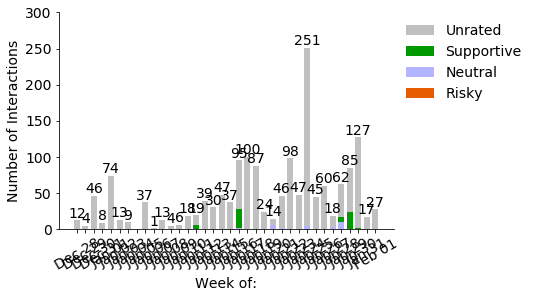

+vinny


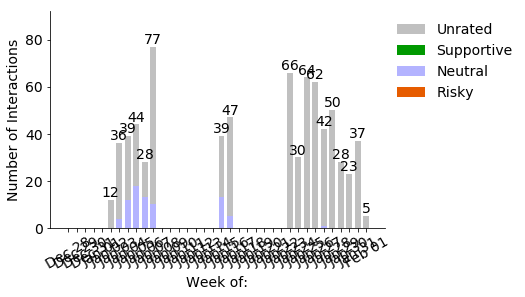

jake


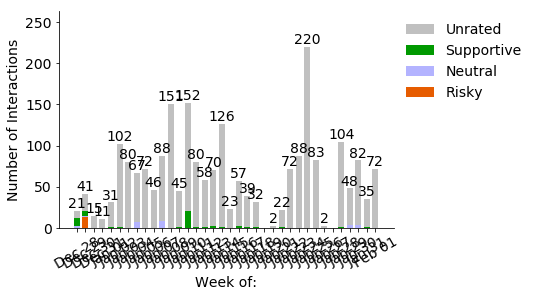

hayyogirl


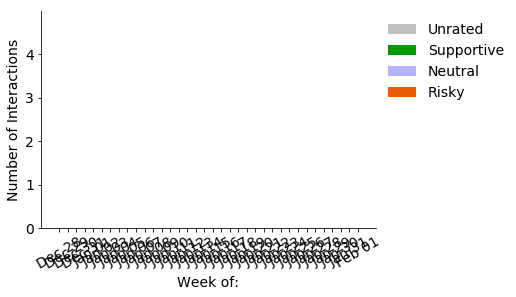

rabbit


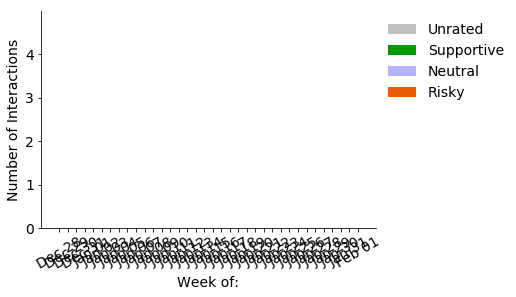

username


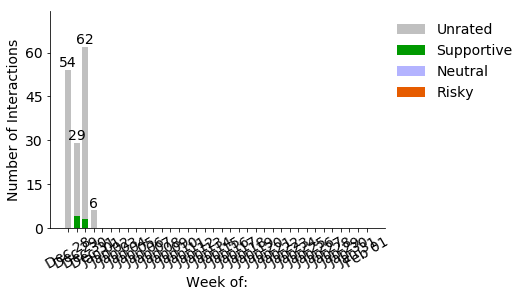

In [13]:
comm_vol_bar_chart_cols = ['total_comm', 'risky_comm', 'neutral_comm', 'supportive_comm', 'unrated_comm']
date_indices = pd.date_range(today - dt.timedelta(35), today + dt.timedelta(0), freq='D')

for username in usernames:
    print(username)
    comm_vol_bar_chart_data = daily_comm_dict[username][comm_vol_bar_chart_cols]
#     print(comm_vol_bar_chart_data[comm_vol_bar_chart_data.index >= date_indices[0]])
    comm_vol_bar_chart_data = comm_vol_bar_chart_data[(comm_vol_bar_chart_data.index >= date_indices[0]) & (comm_vol_bar_chart_data.index <= date_indices[-1])]
    generate_report_charts.comm_vol_bar_chart([username], date_indices, comm_vol_bar_chart_data, chart_path, show=True)

    
    